In [1]:
import os
import sys
import torch
import uproot
import numpy as np
from collections import OrderedDict
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pickle
import argparse

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

from Common import *
import time
import imp

3.10.8


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
module = "./PuppiJetMETHTModel.py"
weights = "./PuppiJetMETHT_NoCut_Deep_200Epoch.pth"
modulename = 'ZhenbinModel'
exec("from %s import *" % modulename)
sys.stdout = open("%s.log" % modelname, 'w')

start = time.time()
features = sum([v[0] for b, v in PhysicsObt.items()])

bg = P2L1NTP(bg_files, PhysicsObt,  cutfunc=globalcutfunc)
dataloader = DataLoader(bg, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=False)

model = autoencoder(features)
model.load_state_dict(torch.load(weights, map_location='cpu'))

if torch.cuda.is_available():
    model = model.cuda()
print (model.parameters)

In [4]:
criterion = torch.nn.L1Loss(reduction='none')
lossMap = {}


In [5]:
inputData = []
outputData = []
latentData = []
for i, data in enumerate(dataloader):
    output = model(data)
    if len(inputData)==0: 
        inputData = data.numpy().astype(np.float32)
        latentData = model.encoder(data).detach().numpy().astype(np.float32)
        outputData = output.detach().numpy().astype(np.float32)
    else:
        inputData = np.concatenate((inputData, data.numpy().astype(np.float32)), axis=0)
        latentData = np.concatenate((latentData, model.encoder(data).detach().numpy().astype(np.float32)), axis=0)
        outputData = np.concatenate((outputData, output.detach().numpy().astype(np.float32)), axis=0)
        

### Compare Input/Output for Background 

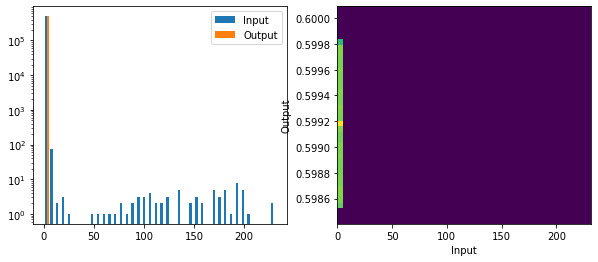

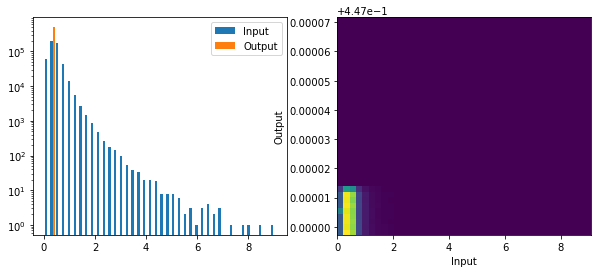

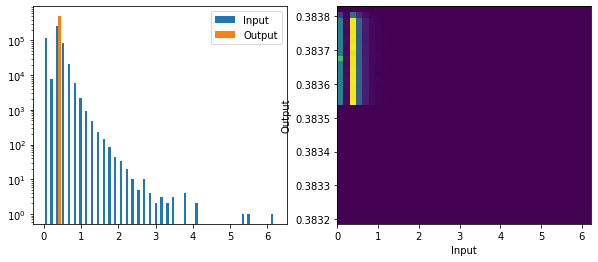

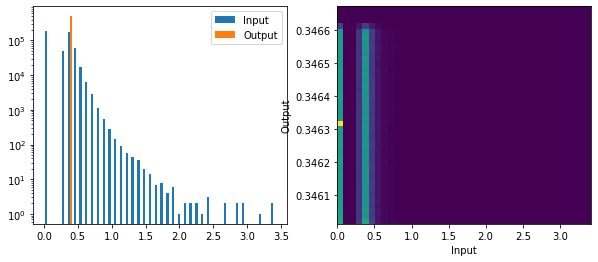

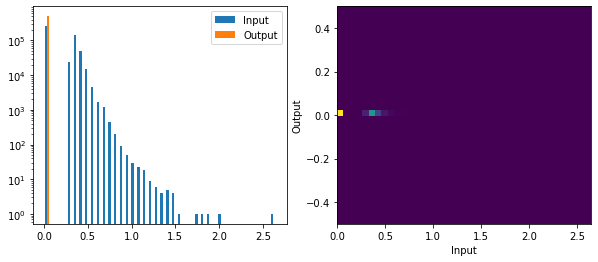

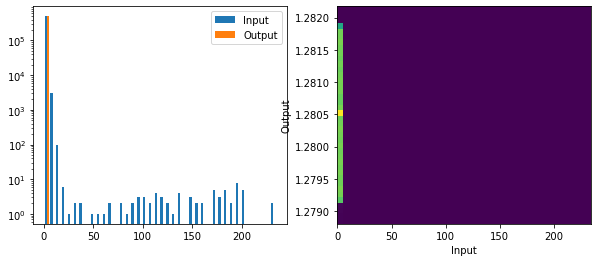

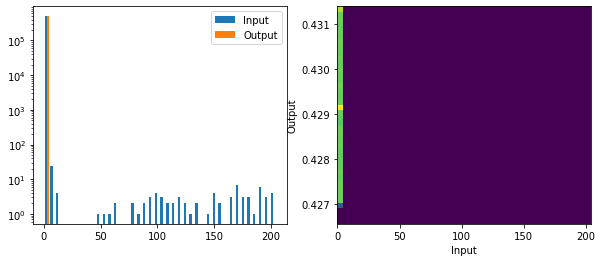

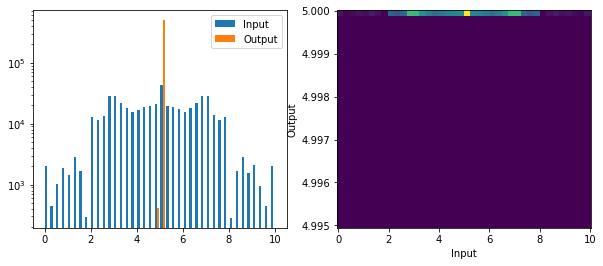

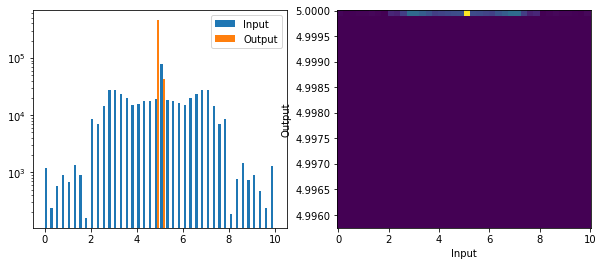

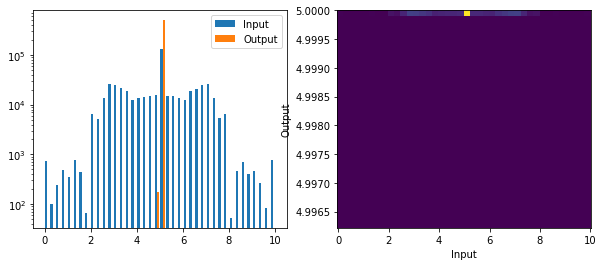

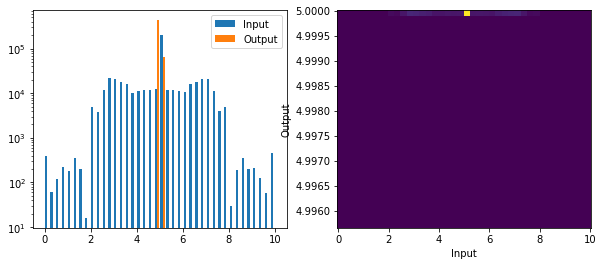

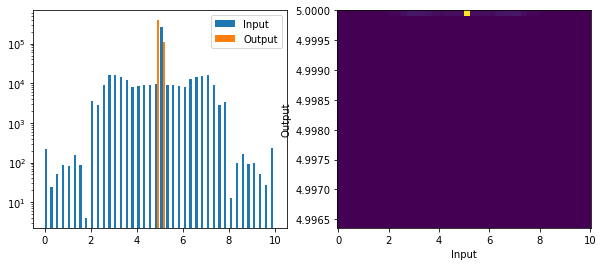

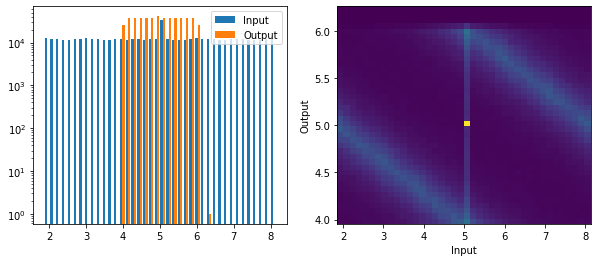

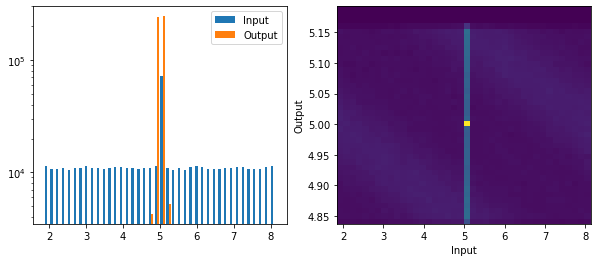

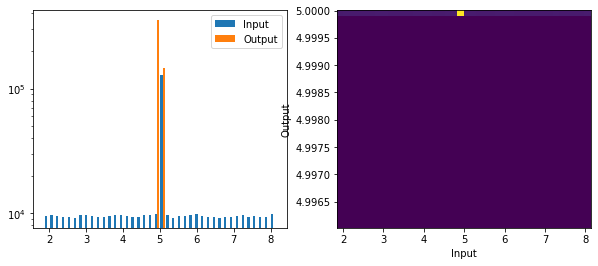

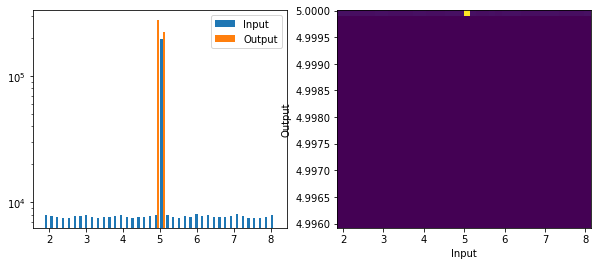

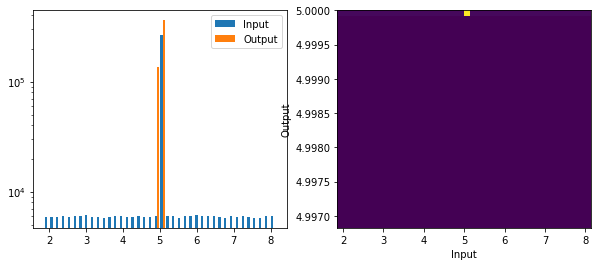

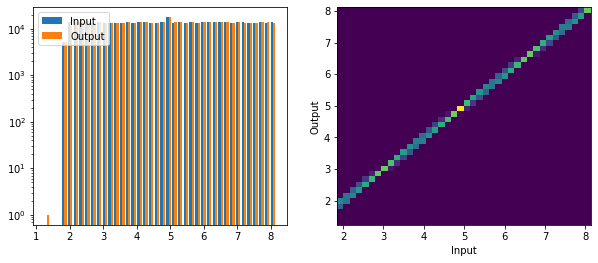

In [33]:

for i in range(outputData.shape[1]):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist([inputData[:,i].flatten(), outputData[:,i].flatten()],bins=40, label=['Input', 'Output'])
    plt.yscale('log')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist2d(inputData[:,i].flatten(),outputData[:,i].flatten(),bins=40)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.show()


## Compare Input/Output for Signal VBF_HToInvisible

In [10]:
sg = P2L1NTP(sg_files, PhysicsObt,  cutfunc=globalcutfunc)
dataloader_sg = DataLoader(sg, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=False)


In [11]:
inputSignal = []
outputSignal = []
latentSignal = []
for i, Signal in enumerate(dataloader_sg):
    output = model(Signal)
    if len(inputSignal)==0: 
        inputSignal = Signal.numpy().astype(np.float32)
        latentSignal = model.encoder(Signal).detach().numpy().astype(np.float32)
        outputSignal = output.detach().numpy().astype(np.float32)
    else:
        inputSignal = np.concatenate((inputSignal, Signal.numpy().astype(np.float32)), axis=0)
        latentSignal = np.concatenate((latentSignal, model.encoder(Signal).detach().numpy().astype(np.float32)), axis=0)
        outputSignal = np.concatenate((outputSignal, output.detach().numpy().astype(np.float32)), axis=0)
        

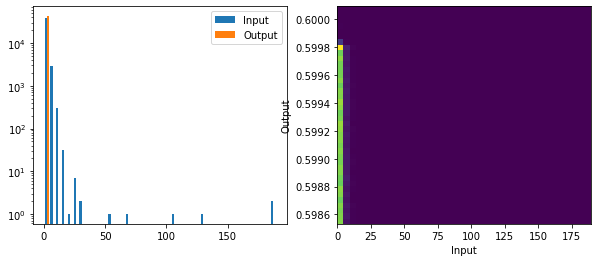

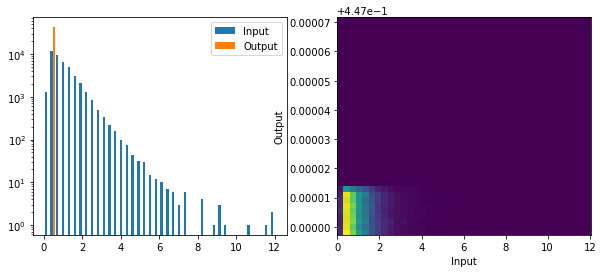

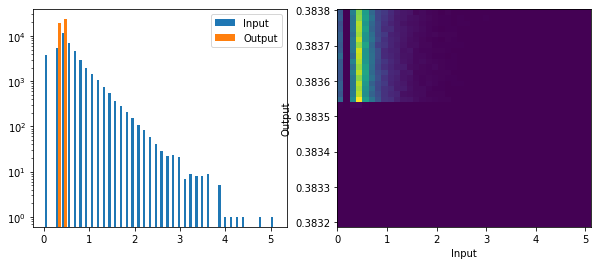

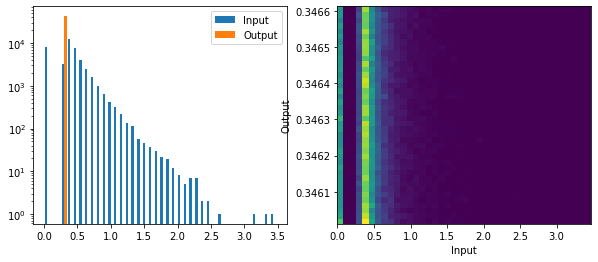

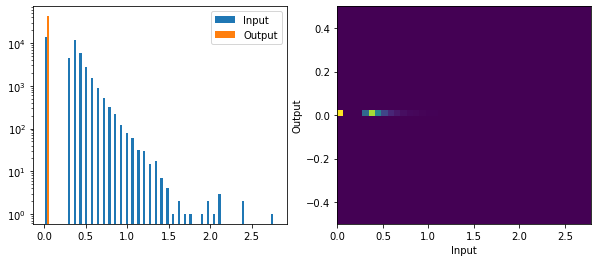

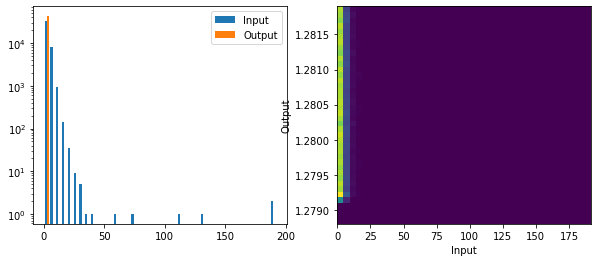

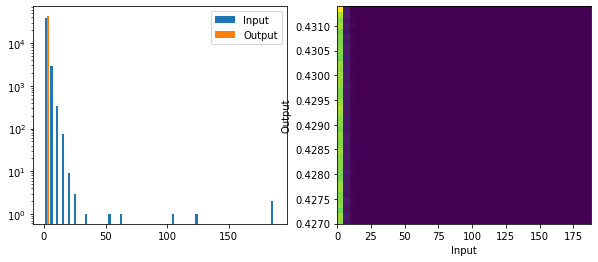

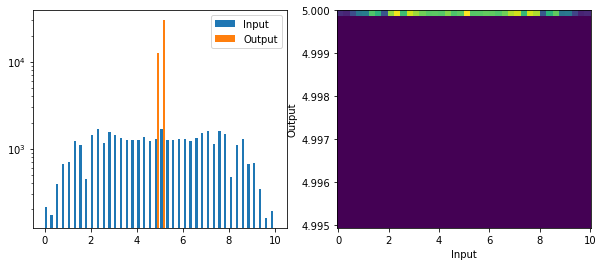

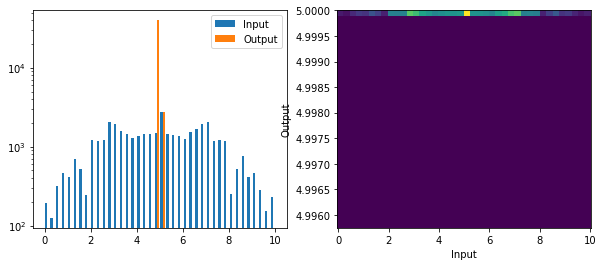

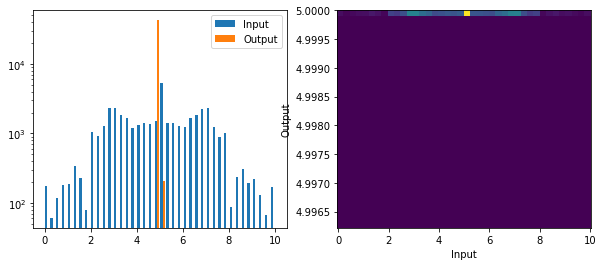

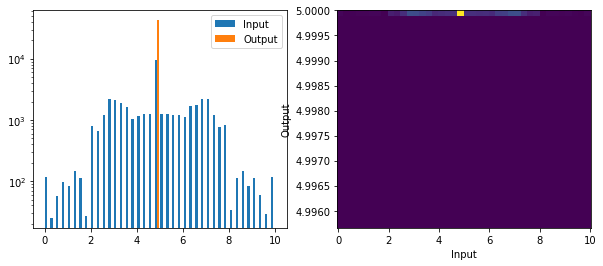

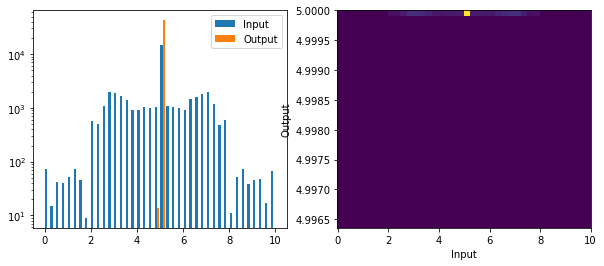

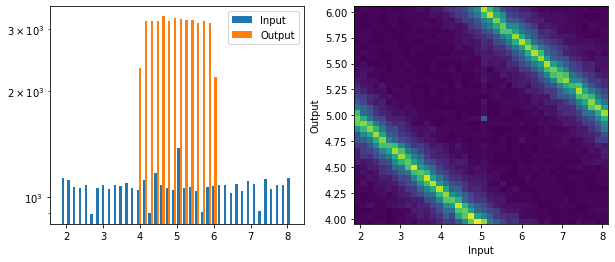

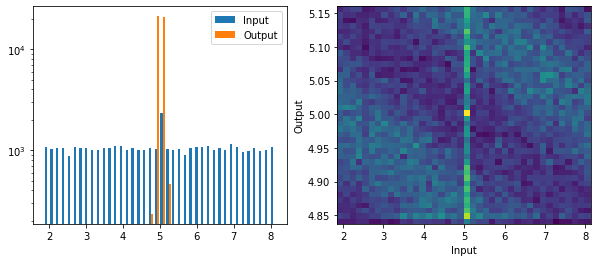

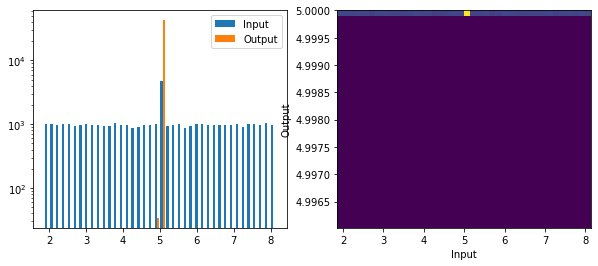

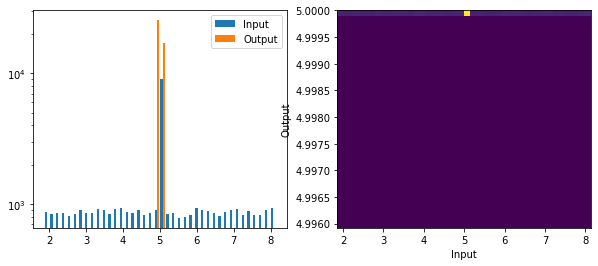

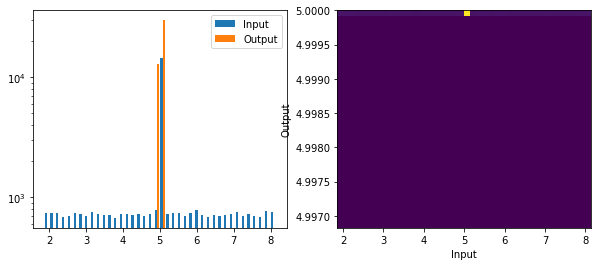

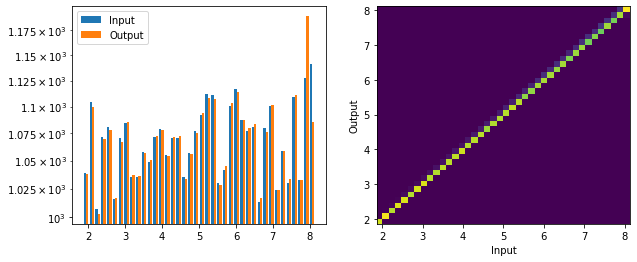

In [7]:
for i in range(outputSignal.shape[1]):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist([inputSignal[:,i].flatten(), outputSignal[:,i].flatten()],bins=40, label=['Input', 'Output'])
    plt.yscale('log')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist2d(inputSignal[:,i].flatten(),outputSignal[:,i].flatten(),bins=40)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.show()


### Comparing the latent space

In [11]:
latentData

array([[0.       , 0.       , 0.       , 0.8176626, 0.       , 2.749787 ],
       [0.       , 0.       , 0.       , 0.9086025, 0.       , 0.9492785],
       [0.       , 0.       , 0.       , 0.8866639, 0.       , 1.3974212],
       ...,
       [0.       , 0.       , 0.       , 0.7747473, 0.       , 3.623751 ],
       [0.       , 0.       , 0.       , 0.7499847, 0.       , 4.075869 ],
       [0.       , 0.       , 0.       , 0.8375404, 0.       , 2.312733 ]],
      dtype=float32)

In [12]:
idx_max = 1000
from sklearn.manifold import TSNE

z_dset = np.array([])
z_dset = np.concatenate((z_dset, latentData[:idx_max])) if z_dset.size else latentData[:idx_max]
z_dset = np.concatenate((z_dset, latentSignal[:idx_max]))
z_embedded = TSNE(n_components=2).fit_transform(z_dset)


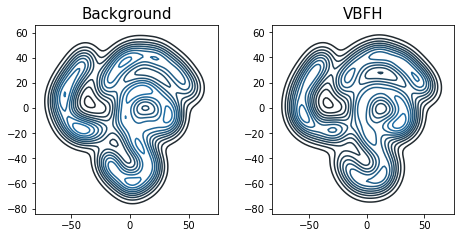

In [13]:
import seaborn as sns
all_labels = ['Background','VBFH']
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, n in enumerate(all_labels):
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    ax = plt.subplot(2,4,i+1)
    sns.kdeplot(aux_z[:,0], aux_z[:,1], ax=ax)
    #ax.set_xlabel('Embedded 0')
    #ax.set_ylabel('Embedded 1')
    ax.set_title(n, fontsize=15)
plt.show()
        

### Compare outputs of Background and Signal to see if they are really the same

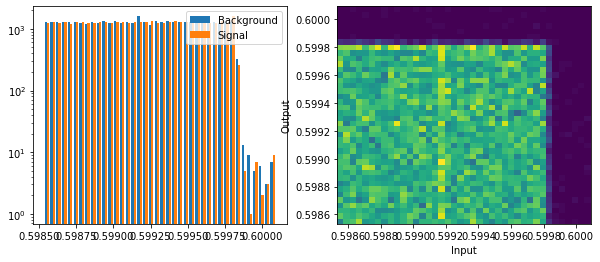

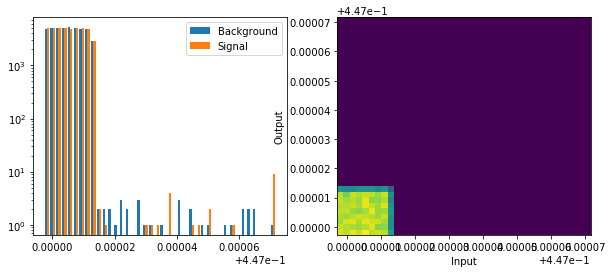

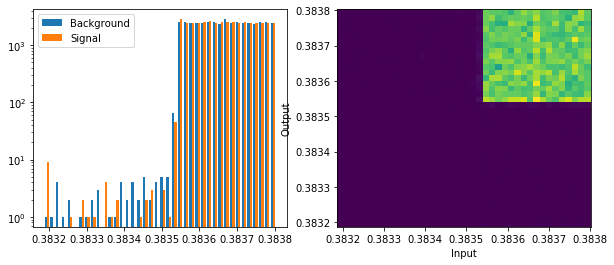

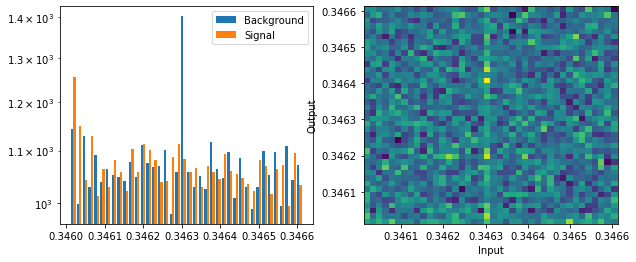

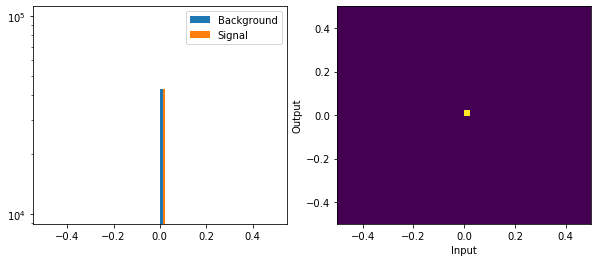

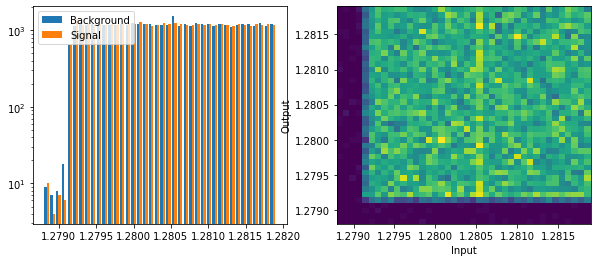

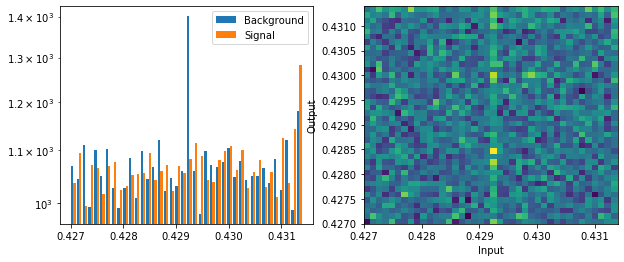

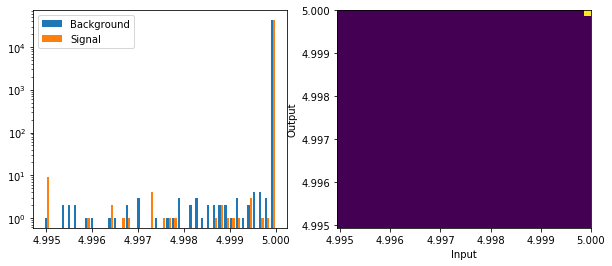

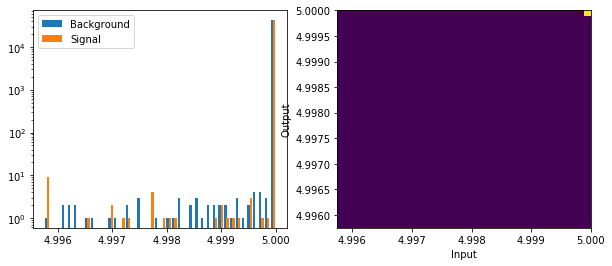

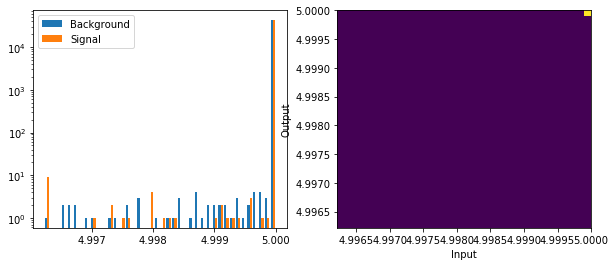

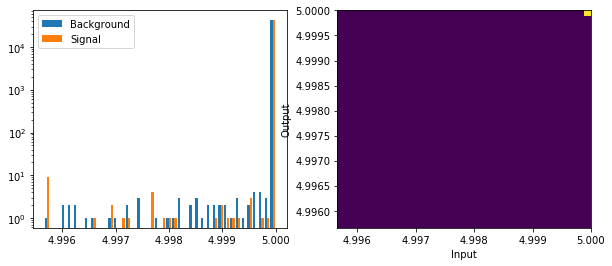

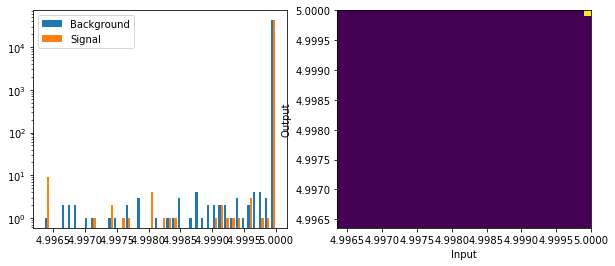

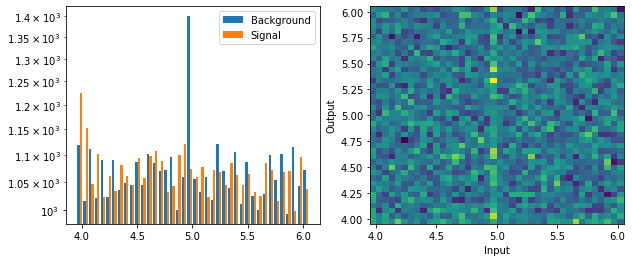

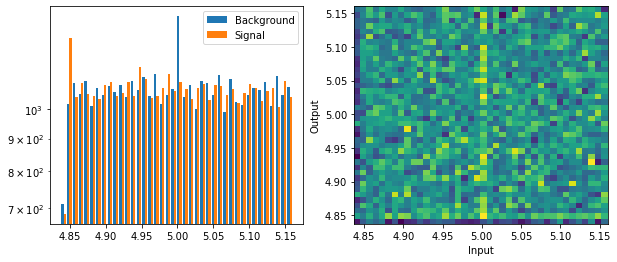

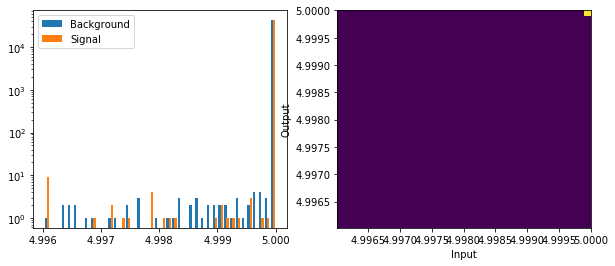

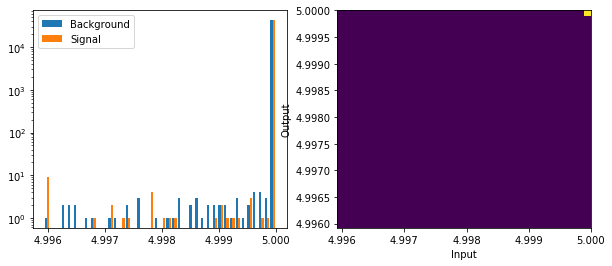

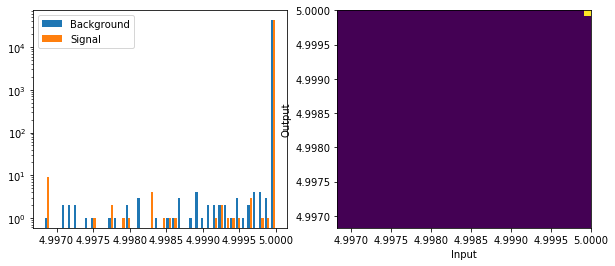

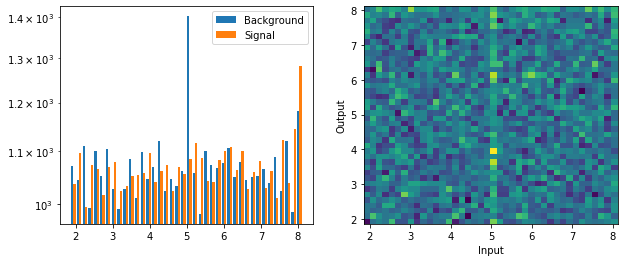

In [15]:
maxEvents = len(outputSignal)
for i in range(outputSignal.shape[1]):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist([outputData[:maxEvents,i].flatten(), outputSignal[:,i].flatten()],bins=40, label=['Background', 'Signal'])
    plt.yscale('log')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist2d(outputData[:maxEvents,i].flatten(),outputSignal[:,i].flatten(),bins=40)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.show()


## Compare Input/Output for Signal GluGluToHHTo4B

In [6]:
sg3 = P2L1NTP(sg_files3, PhysicsObt,  cutfunc=globalcutfunc)
dataloader_sg3 = DataLoader(sg3, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=False)

inputSignal3 = []
outputSignal3 = []
latentSignal3 = []
for i, Signal in enumerate(dataloader_sg3):
    output = model(Signal)
    if len(inputSignal3)==0: 
        inputSignal3 = Signal.numpy().astype(np.float32)
        latentSignal3 = model.encoder(Signal).detach().numpy().astype(np.float32)
        outputSignal3 = output.detach().numpy().astype(np.float32)
    else:
        inputSignal3 = np.concatenate((inputSignal3, Signal.numpy().astype(np.float32)), axis=0)
        latentSignal3 = np.concatenate((latentSignal3, model.encoder(Signal).detach().numpy().astype(np.float32)), axis=0)
        outputSignal3 = np.concatenate((outputSignal3, output.detach().numpy().astype(np.float32)), axis=0)
        


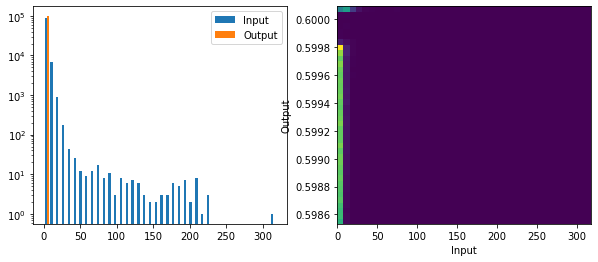

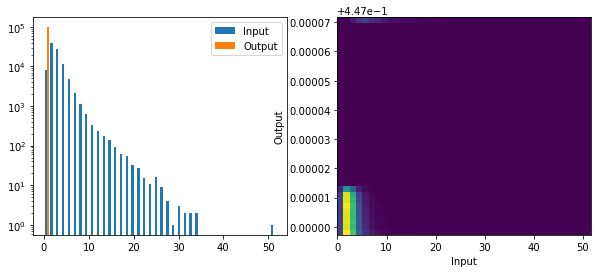

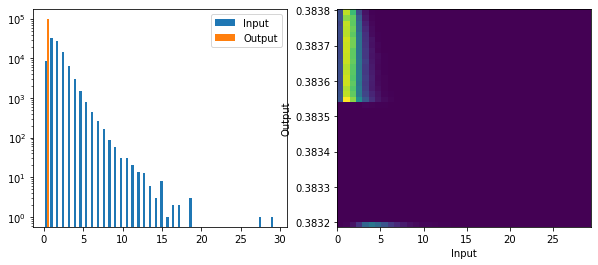

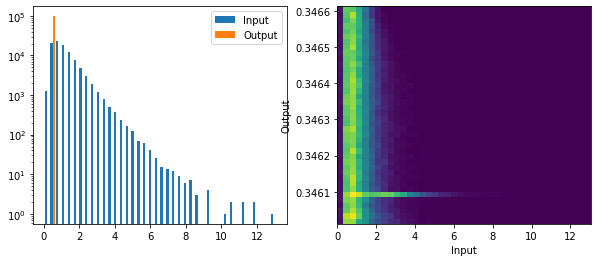

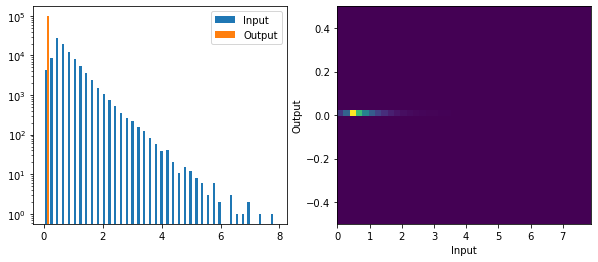

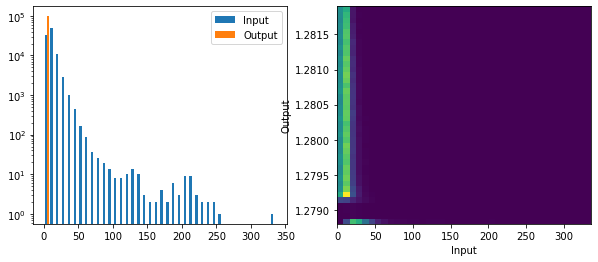

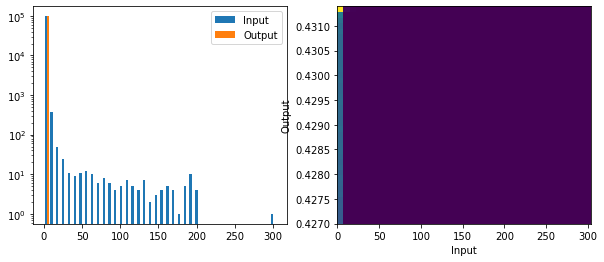

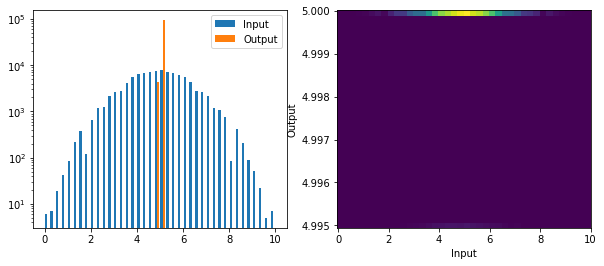

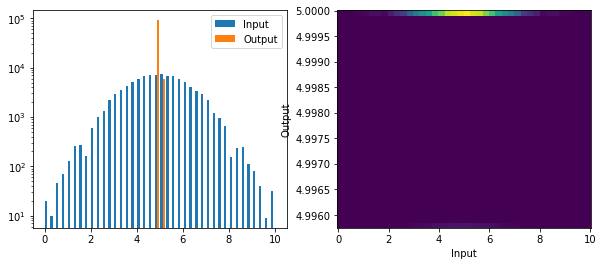

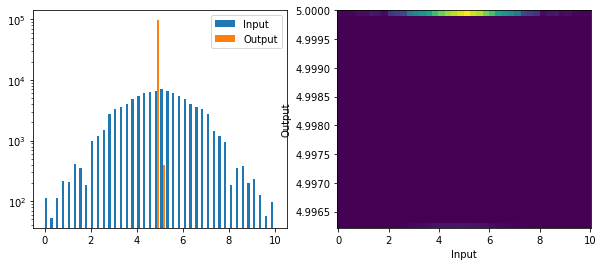

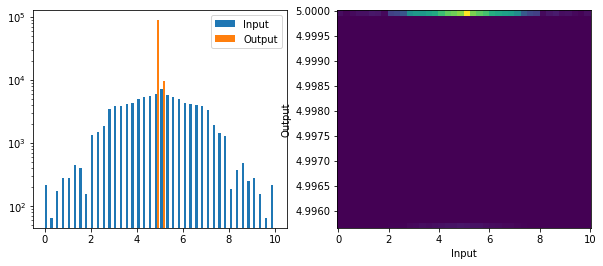

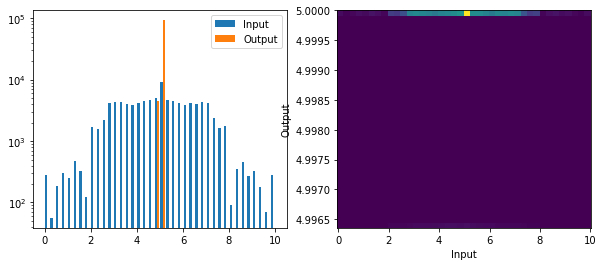

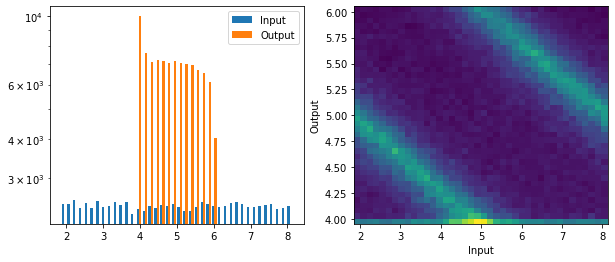

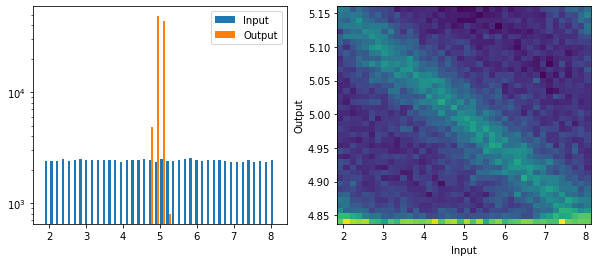

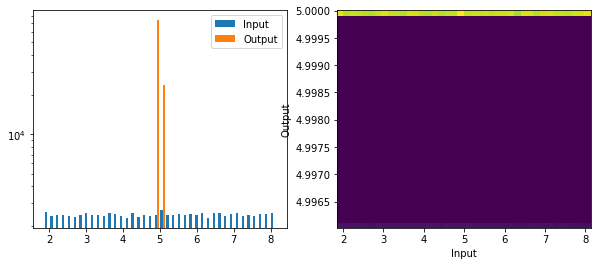

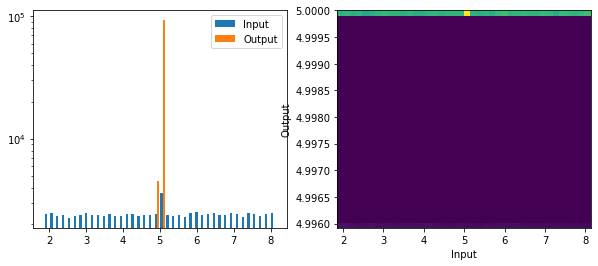

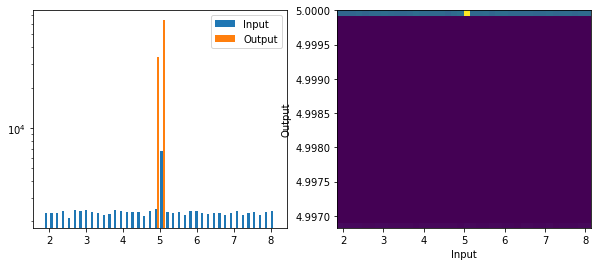

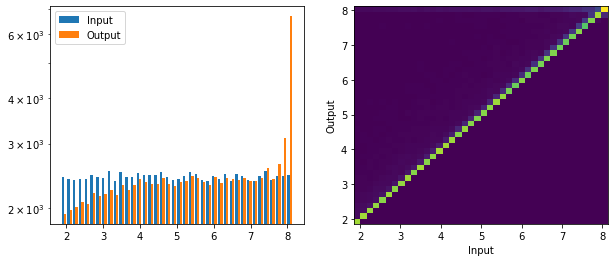

In [7]:
for i in range(outputSignal3.shape[1]):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist([inputSignal3[:,i].flatten(), outputSignal3[:,i].flatten()],bins=40, label=['Input', 'Output'])
    plt.yscale('log')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist2d(inputSignal3[:,i].flatten(),outputSignal3[:,i].flatten(),bins=40)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.show()


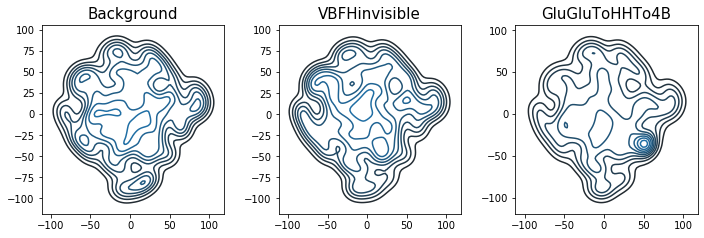

In [12]:
idx_max = 2000
from sklearn.manifold import TSNE

z_dset = np.array([])
z_dset = np.concatenate((z_dset, latentData[:idx_max])) if z_dset.size else latentData[:idx_max]
z_dset = np.concatenate((z_dset, latentSignal[:idx_max]))
z_dset = np.concatenate((z_dset, latentSignal3[:idx_max]))
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

import seaborn as sns
all_labels = ['Background','VBFHinvisible', 'GluGluToHHTo4B']
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, n in enumerate(all_labels):
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    ax = plt.subplot(2,4,i+1)
    sns.kdeplot(aux_z[:,0], aux_z[:,1], ax=ax)
    #ax.set_xlabel('Embedded 0')
    #ax.set_ylabel('Embedded 1')
    ax.set_title(n, fontsize=15)
plt.show()